In [3]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [4]:
import datetime
import random

import numpy as np
from sklearn.metrics import roc_auc_score as roc_auc
from cases.credit_scoring_problem import get_scoring_data

from fedot.core.chains.chain import Chain
from fedot.core.data.data import InputData
from fedot.core.composer.gp_composer.gp_composer import GPComposerRequirements, GPComposerBuilder
from fedot.core.composer.optimisers.gp_comp.gp_optimiser import GPChainOptimiserParameters, GeneticSchemeTypesEnum
from fedot.core.composer.optimisers.gp_comp.operators.selection import SelectionTypesEnum
from fedot.core.composer.visualisation import ChainVisualiser
from fedot.core.repository.model_types_repository import ModelTypesRepository
from fedot.core.repository.quality_metrics_repository import ClassificationMetricsEnum, ComplexityMetricsEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum
from fedot.core.chains.chain_convert import chain_as_nx_graph
random.seed(12)
np.random.seed(12)

In [5]:
def results_visualization(history, composed_chains):
    visualiser = ChainVisualiser()
    visualiser.visualise_history(history)
    visualiser.pareto_gif_create(history.archive_history, history.chains)
    visualiser.boxplots_gif_create(history.chains)
    for chain_evo_composed in composed_chains:
        visualiser.visualise(chain_evo_composed)


def calculate_validation_metric(chain: Chain, dataset_to_validate: InputData) -> float:
    # the execution of the obtained composite models
    predicted = chain.predict(dataset_to_validate)
    # the quality assessment for the simulation results
    roc_auc_value = roc_auc(y_true=dataset_to_validate.target,
                            y_score=predicted.predict)
    return roc_auc_value


def run_credit_scoring_problem(train_file_path, test_file_path,
                               max_lead_time: datetime.timedelta = datetime.timedelta(minutes=5),
                               is_visualise=False):
    task = Task(TaskTypesEnum.classification)
    dataset_to_compose = InputData.from_csv(train_file_path, task=task)
    dataset_to_validate = InputData.from_csv(test_file_path, task=task)

    # the search of the models provided by the framework that can be used as nodes in a chain for the selected task
    available_model_types, _ = ModelTypesRepository().suitable_model(task_type=task.task_type)

    # the choice of the metric for the chain quality assessment during composition
    quality_metric = ClassificationMetricsEnum.ROCAUC
    complexity_metric = ComplexityMetricsEnum.node_num
    metrics = [quality_metric, complexity_metric]
    # the choice and initialisation of the GP search
    composer_requirements = GPComposerRequirements(
        primary=available_model_types,
        secondary=available_model_types, max_arity=3,
        max_depth=3, pop_size=20, num_of_generations=20,
        crossover_prob=0.8, mutation_prob=0.8, max_lead_time=max_lead_time,
        start_depth=2, add_single_model_chains=False)

    # GP optimiser parameters choice
    scheme_type = GeneticSchemeTypesEnum.parameter_free
    optimiser_parameters = GPChainOptimiserParameters(genetic_scheme_type=scheme_type,
                                                      selection_types=[SelectionTypesEnum.spea2])

    # Create builder for composer and set composer params
    builder = GPComposerBuilder(task=task).with_requirements(composer_requirements).with_metrics(
        metrics).with_optimiser_parameters(optimiser_parameters)

    # Create GP-based composer
    composer = builder.build()

    # the optimal chain generation by composition - the most time-consuming task
    chains_evo_composed = composer.compose_chain(data=dataset_to_compose,
                                                 is_visualise=True)

    composer.history.write_composer_history_to_csv()

    if is_visualise:
        results_visualization(composed_chains=chains_evo_composed, history=composer.history)

    chains_roc_auc = []
    for chain_num, chain_evo_composed in enumerate(chains_evo_composed):

        chain_evo_composed.fine_tune_primary_nodes(input_data=dataset_to_compose,
                                                   iterations=50)

        chain_evo_composed.fit(input_data=dataset_to_compose)

        # the quality assessment for the obtained composite models
        roc_on_valid_evo_composed = calculate_validation_metric(chain_evo_composed,
                                                                dataset_to_validate)

        chains_roc_auc.append(roc_on_valid_evo_composed)
        if len(chains_evo_composed) > 1:
            print(f'Composed ROC AUC of chain {chain_num + 1} is {round(roc_on_valid_evo_composed, 3)}')

        else:
            print(f'Composed ROC AUC is {round(roc_on_valid_evo_composed, 3)}')

    return chain_evo_composed

eType: None
Metric evaluation error: Trained model cache is not actual or empty
Trained model cache is not actual or empty
NoneType: None
Metric evaluation error: Trained model cache is not actual or empty
Trained model cache is not actual or empty
NoneType: None
Metric evaluation error: Trained model cache is not actual or empty
Trained model cache is not actual or empty
NoneType: None
Metric evaluation error: Trained model cache is not actual or empty
Trained model cache is not actual or empty
NoneType: None
Metric evaluation error: Trained model cache is not actual or empty
Trained model cache is not actual or empty
NoneType: None
Metric evaluation error: Trained model cache is not actual or empty
Trained model cache is not actual or empty
NoneType: None
Metric evaluation error: Trained model cache is not actual or empty
Trained model cache is not actual or empty
NoneType: None
Metric evaluation error: Trained model cache is not actual or empty
Trained model cache is not actual or e

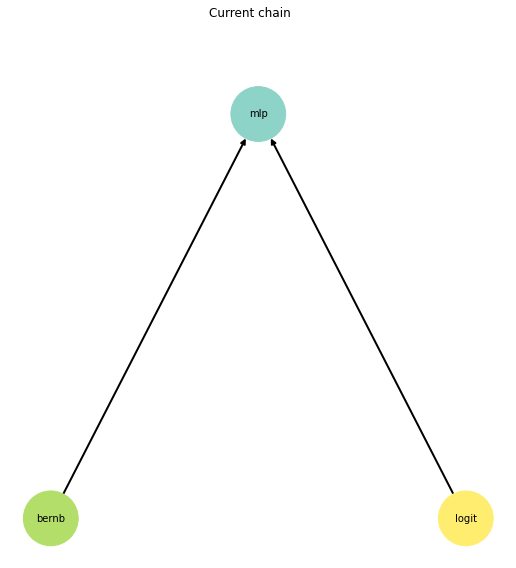

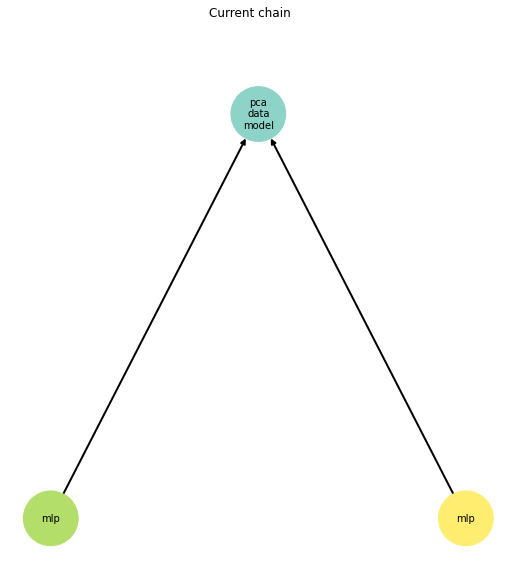

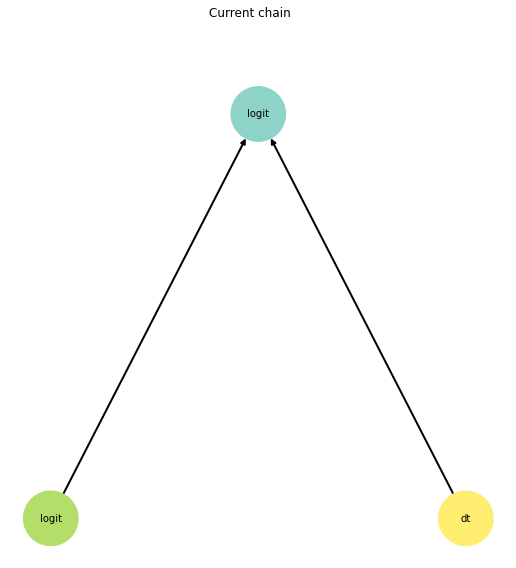

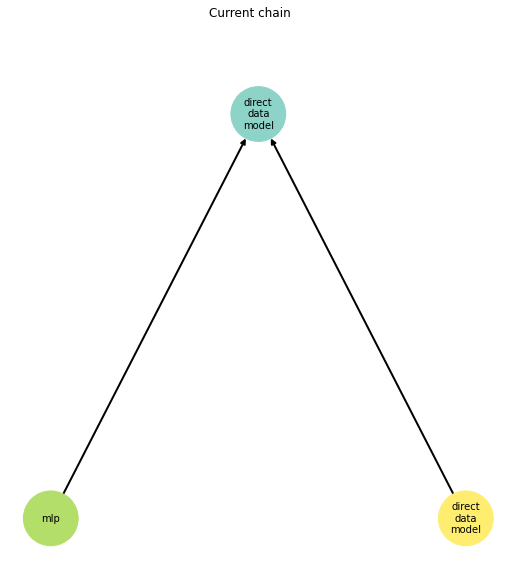

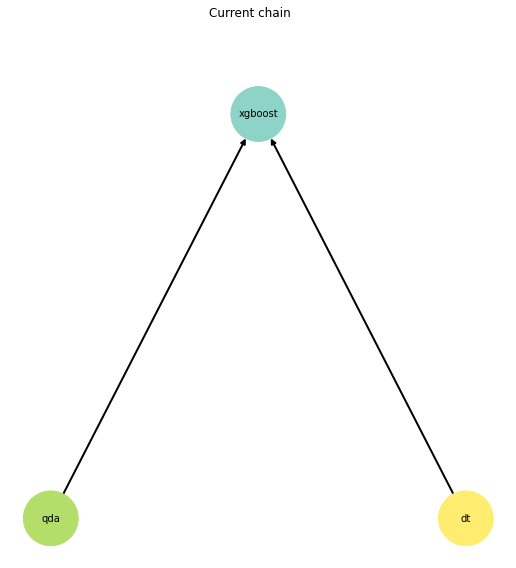

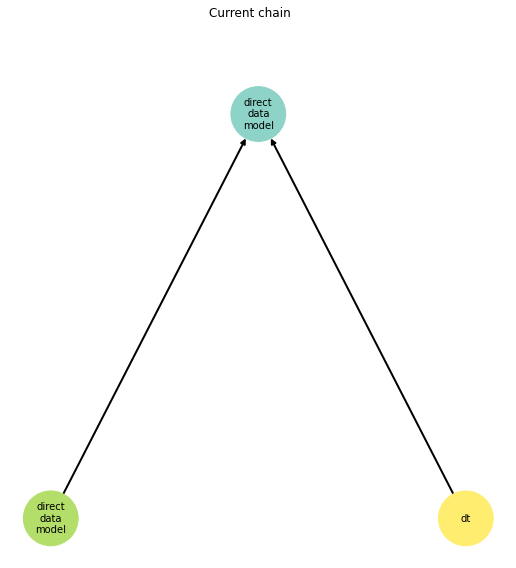

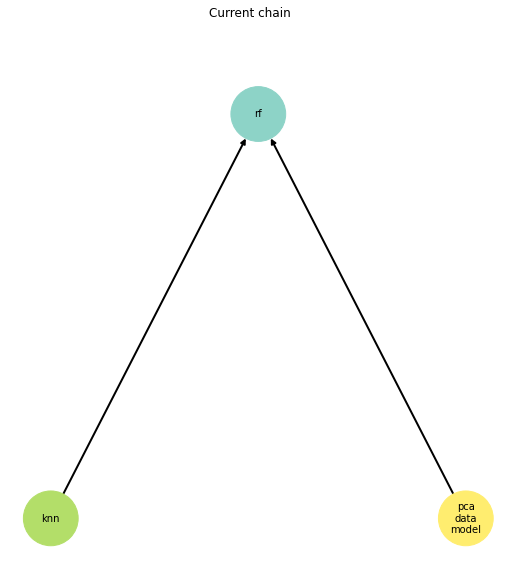

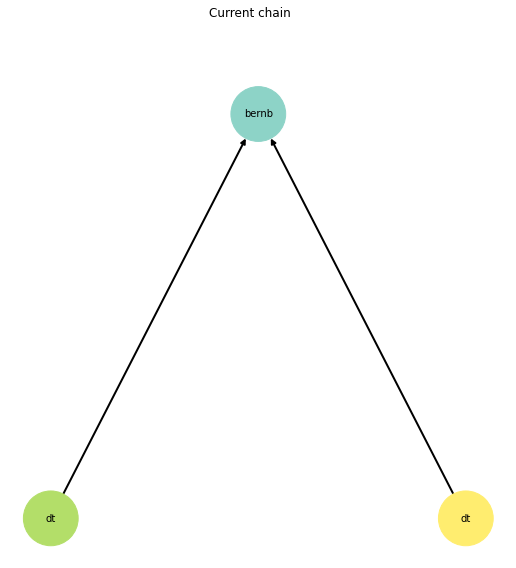

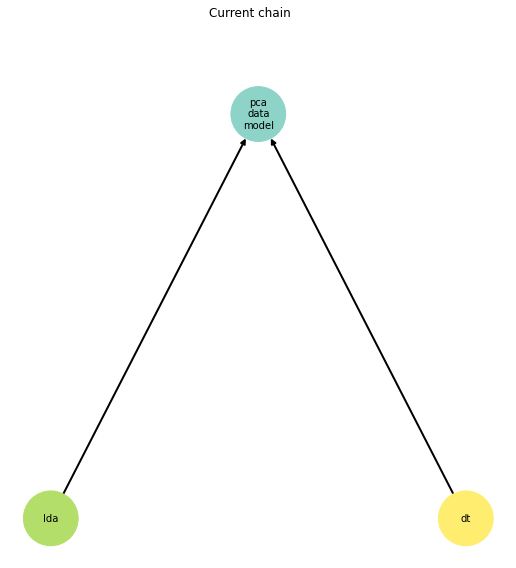

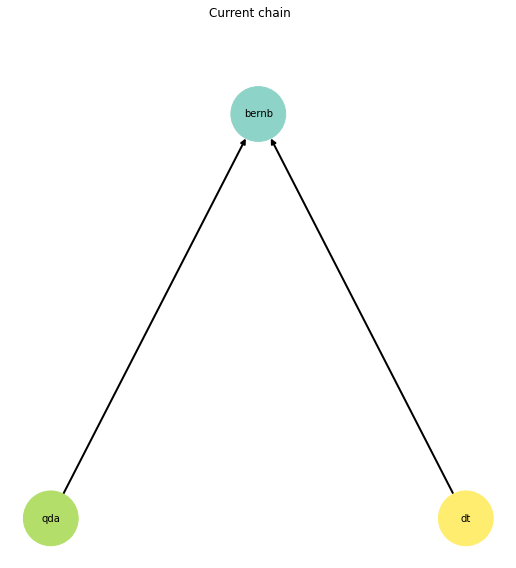

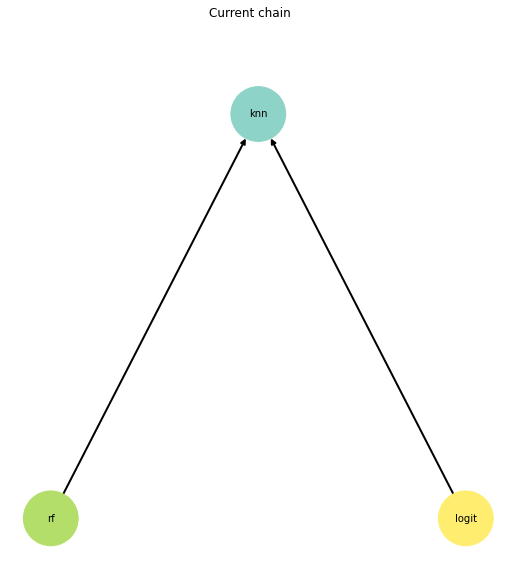

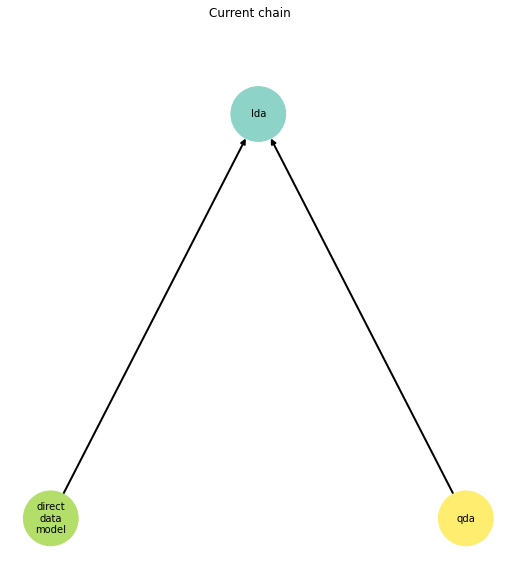

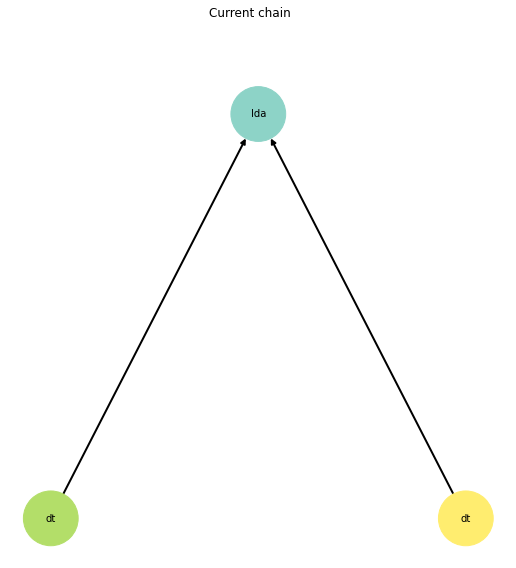

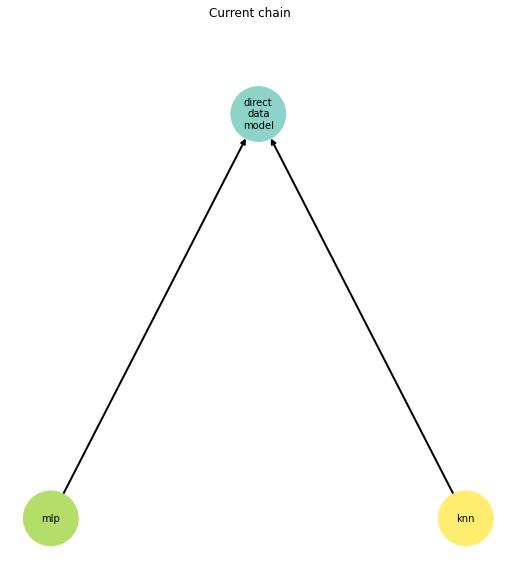

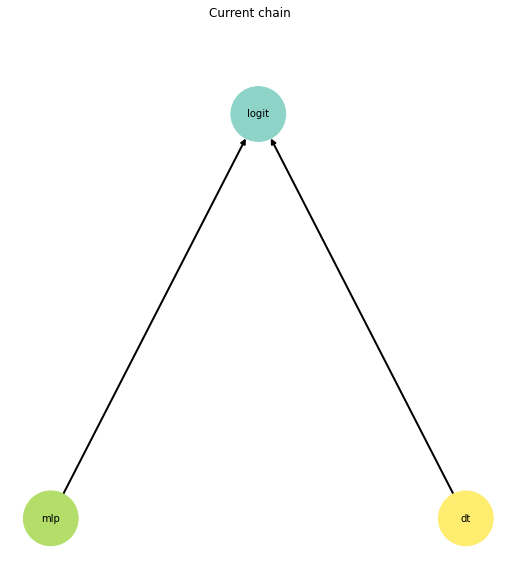

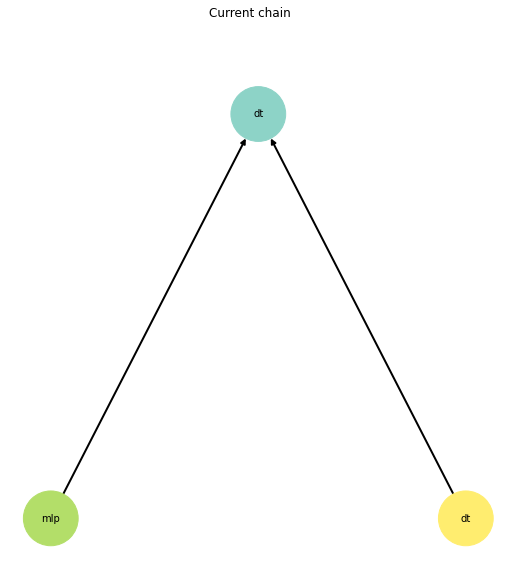

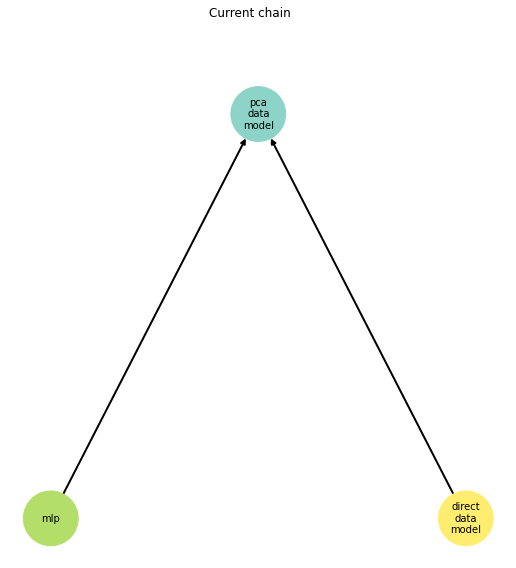

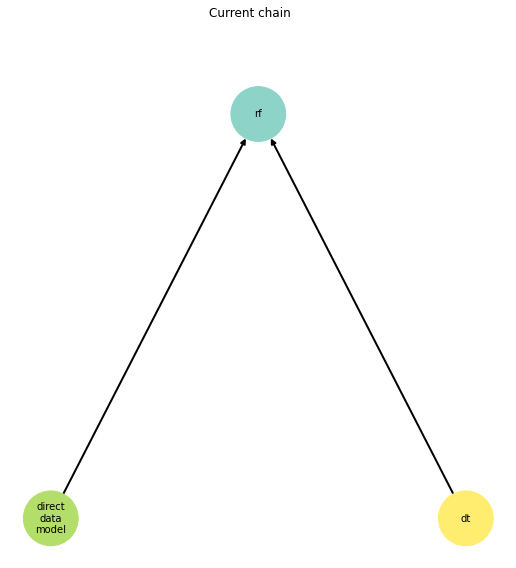

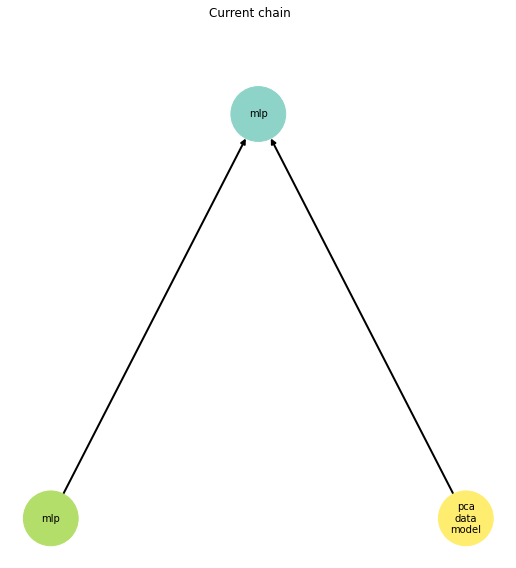

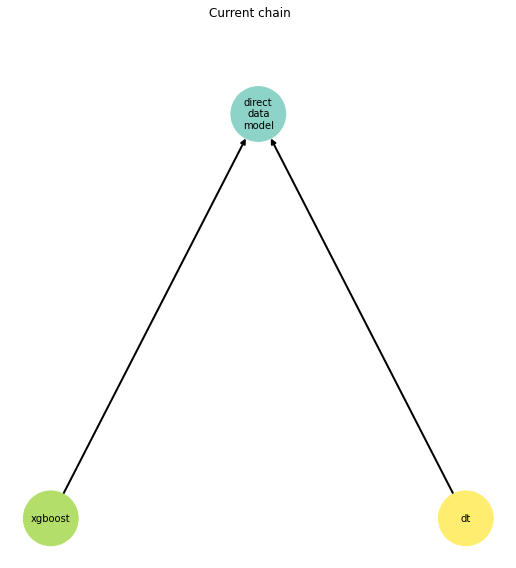

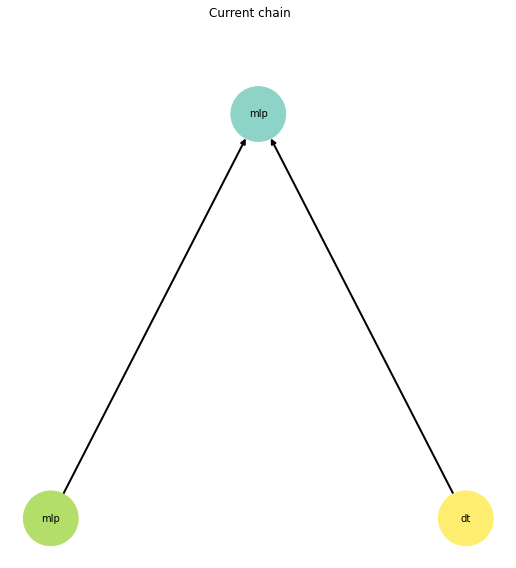

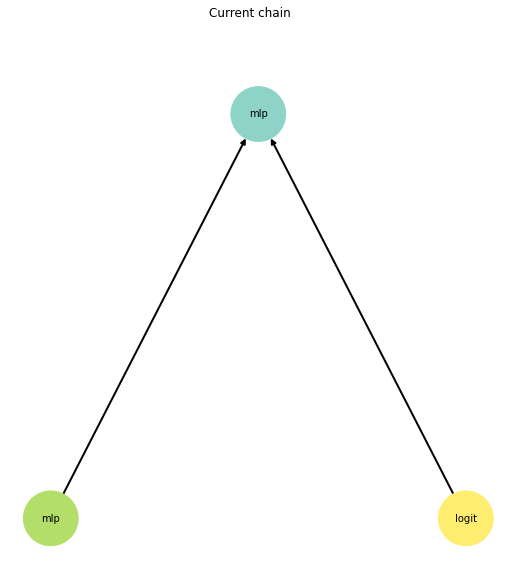

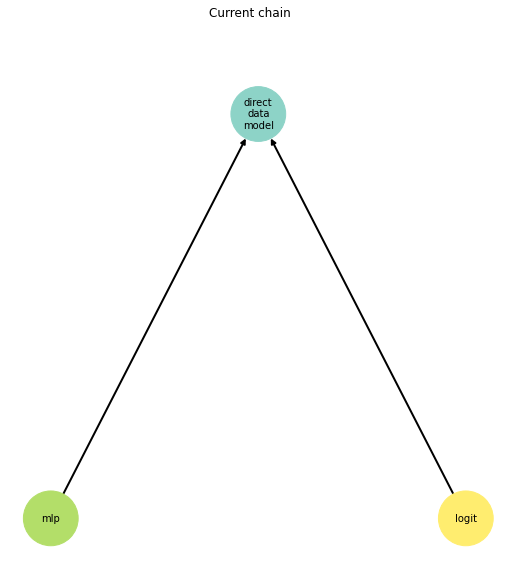

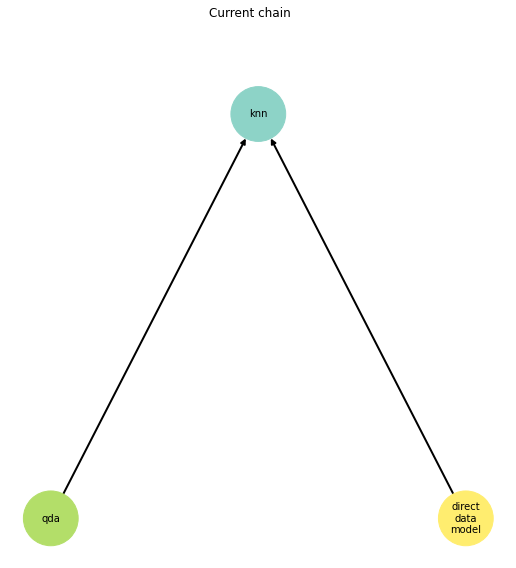

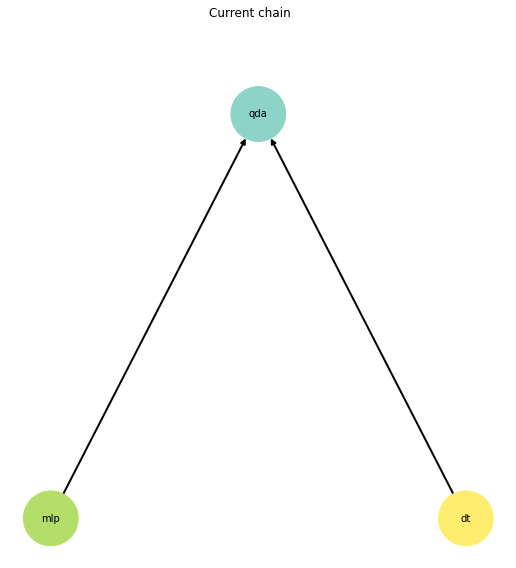

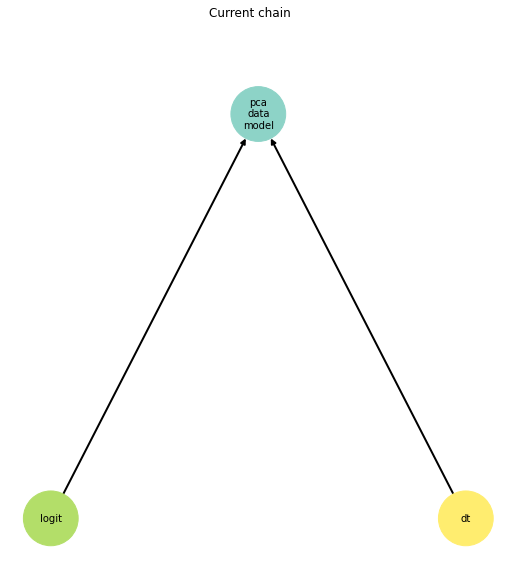

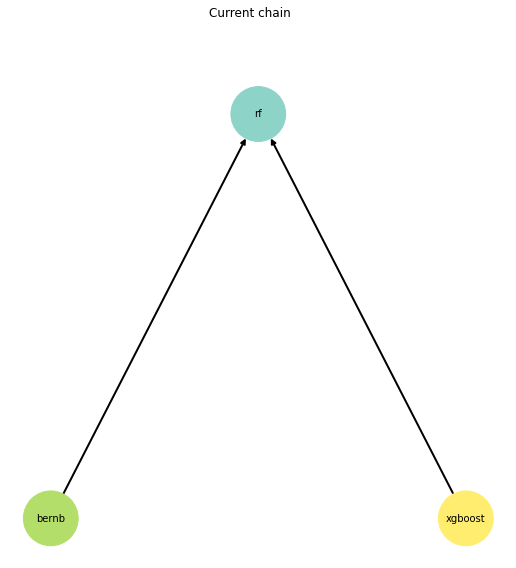

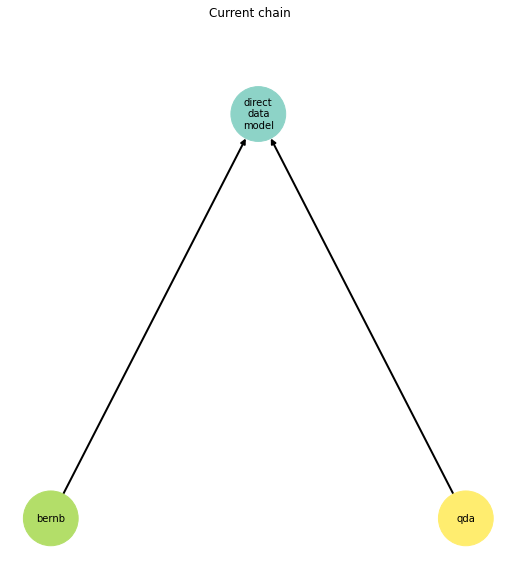

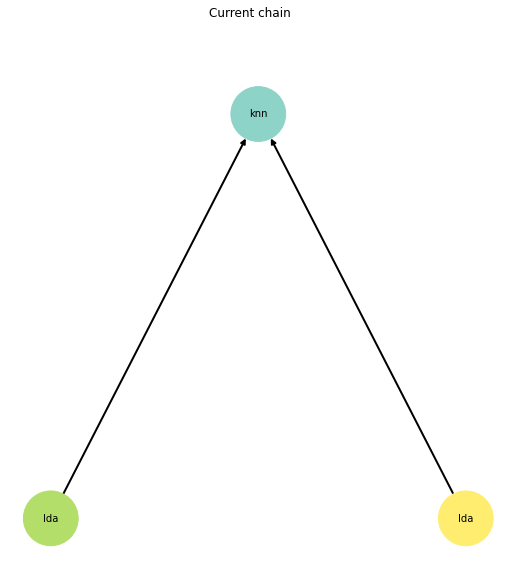

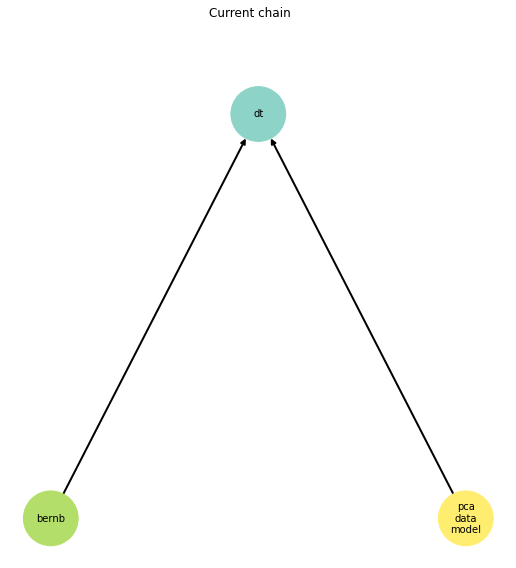

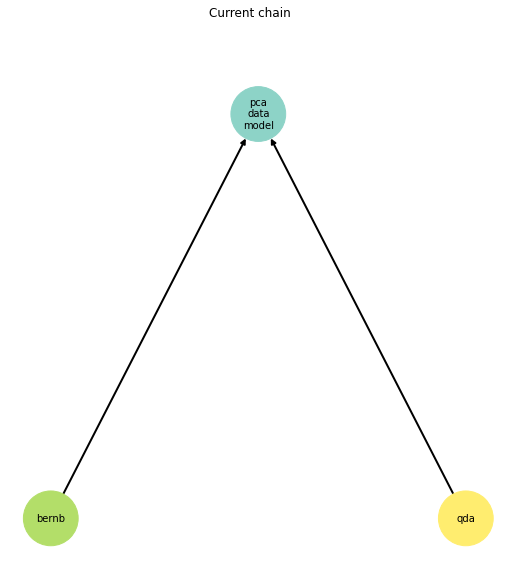

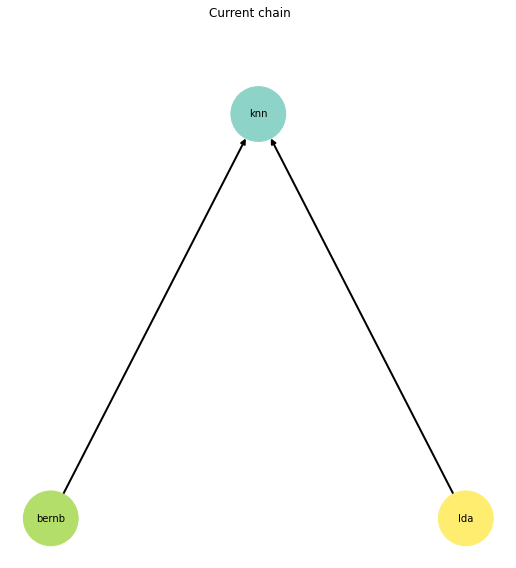

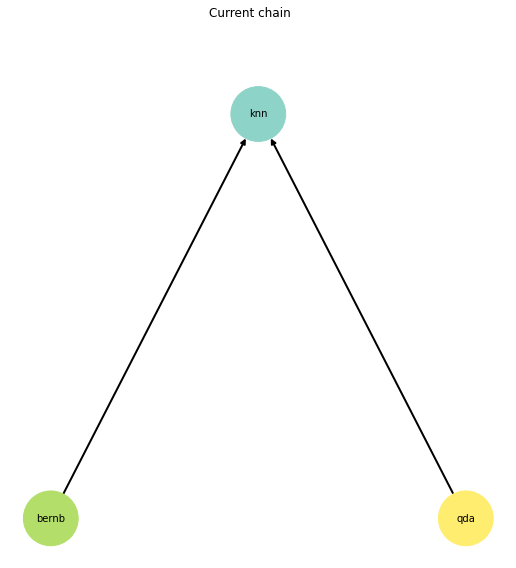

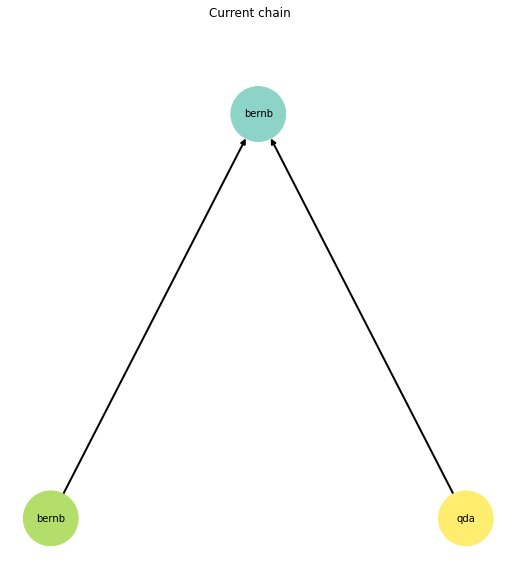

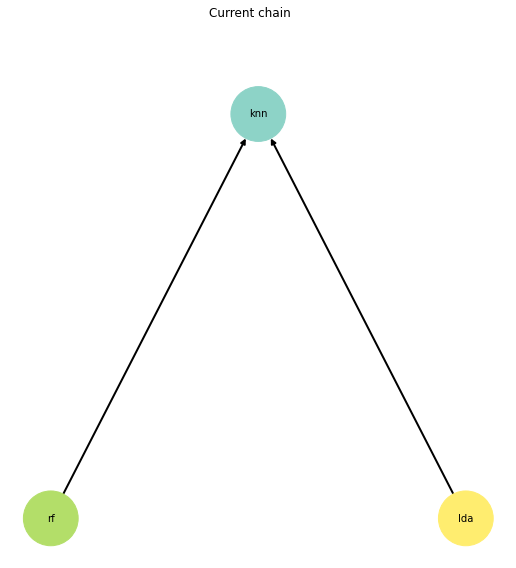

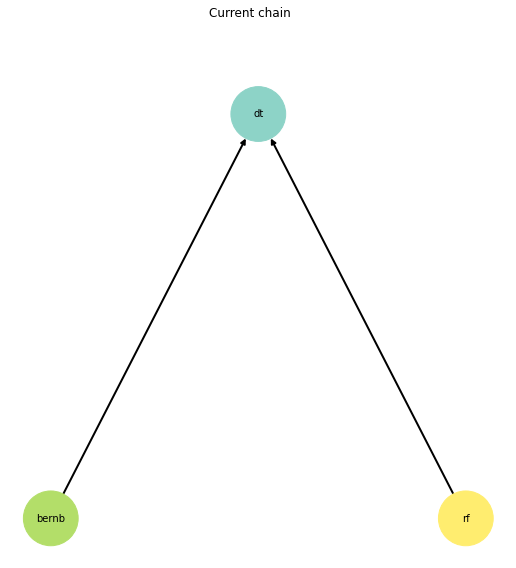

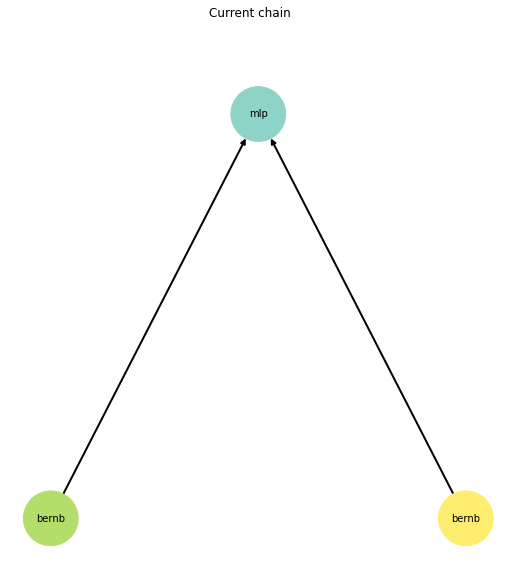

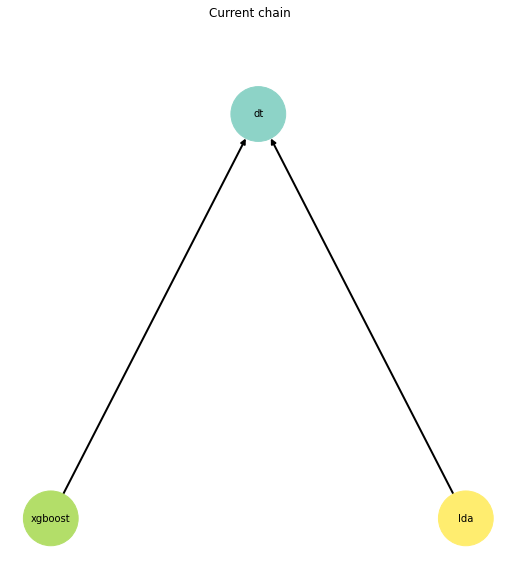

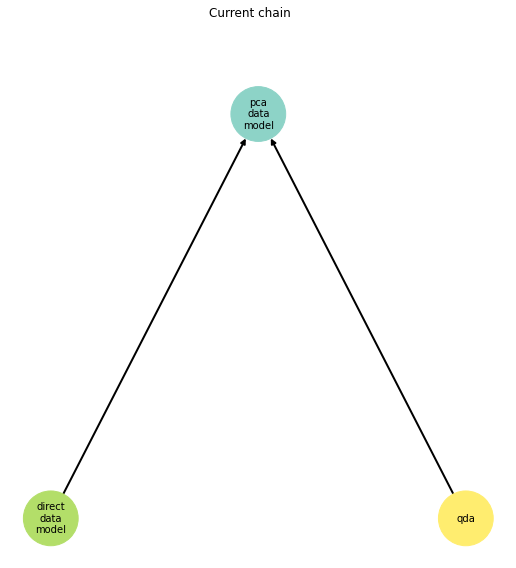

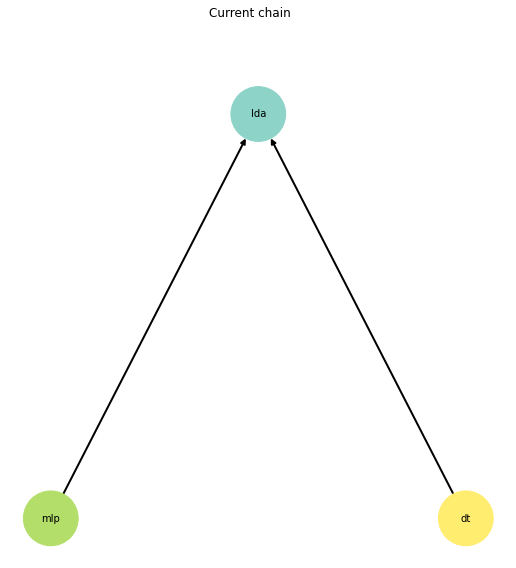

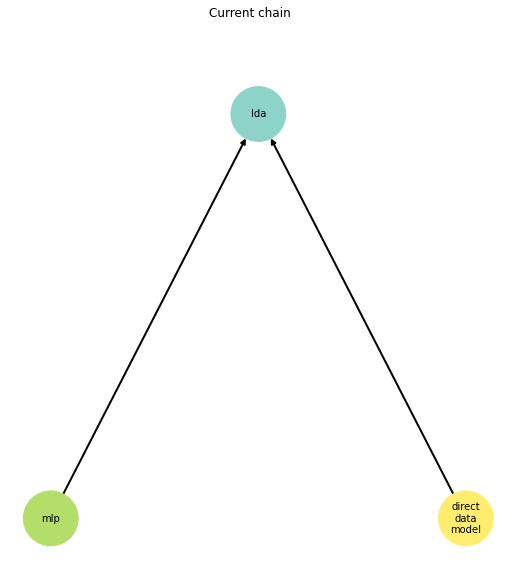

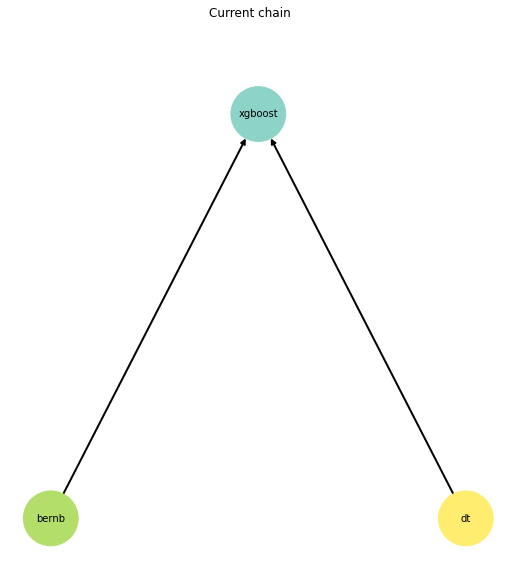

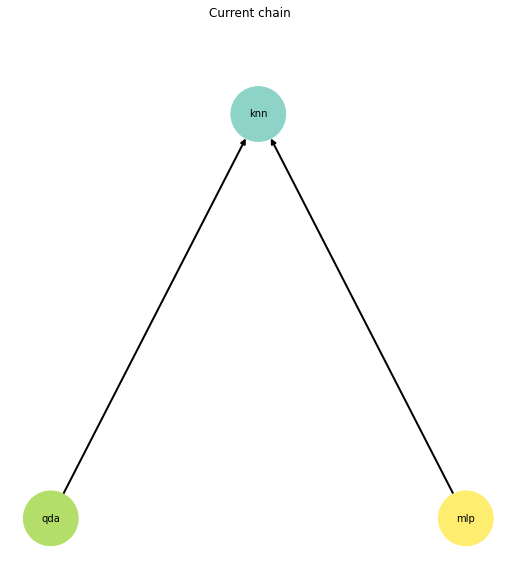

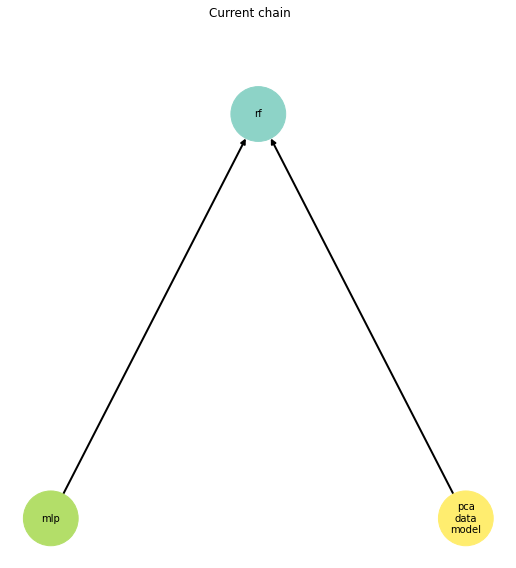

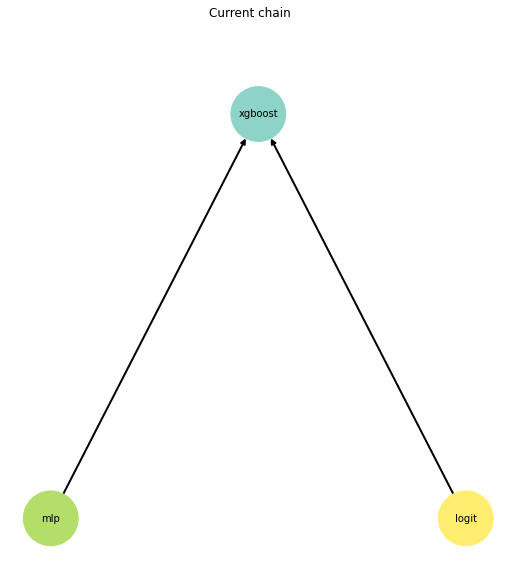

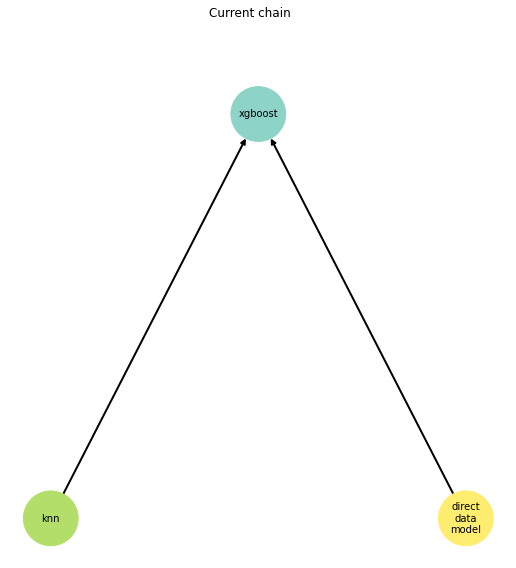

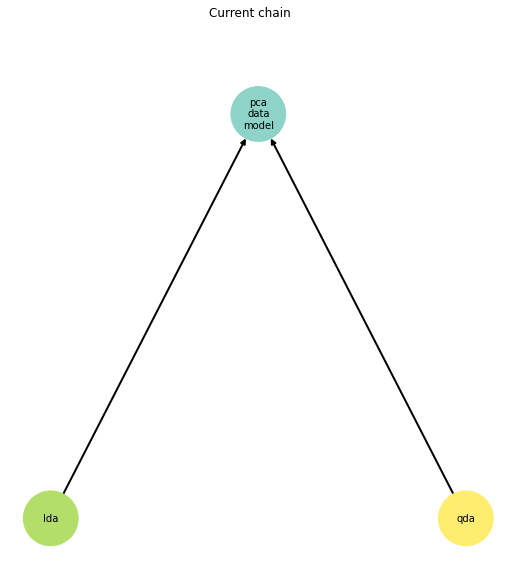

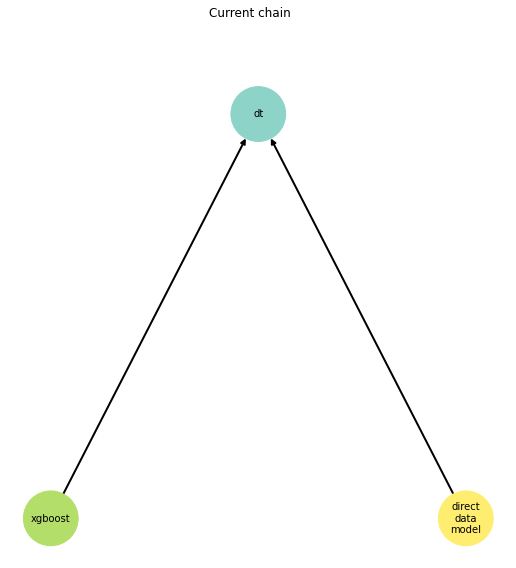

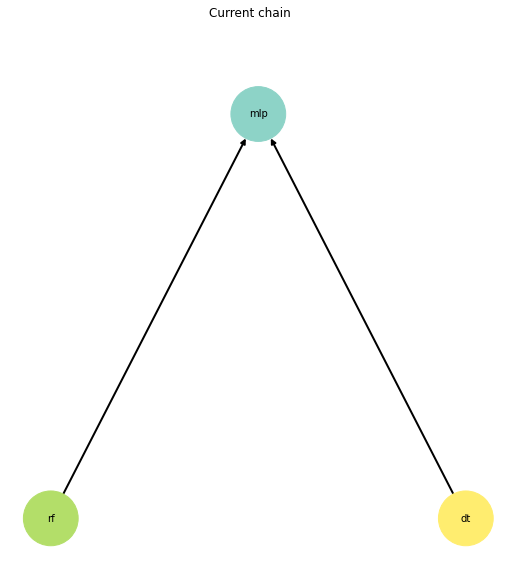

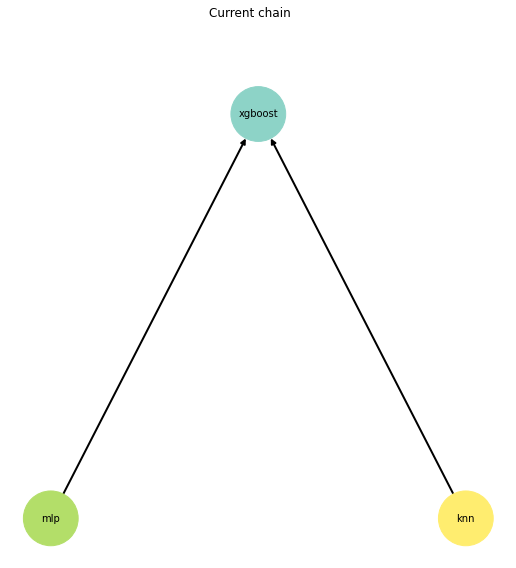

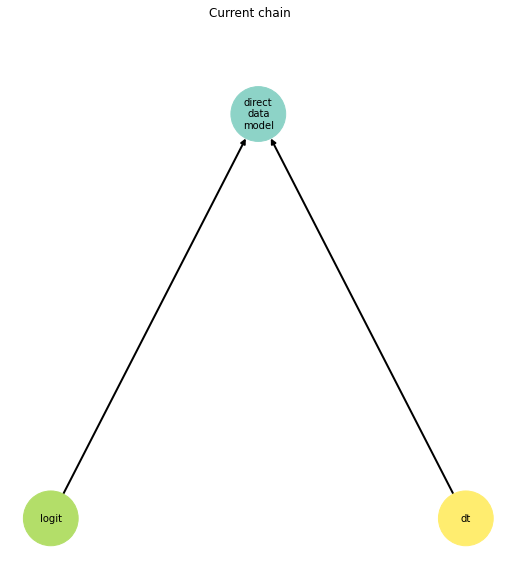

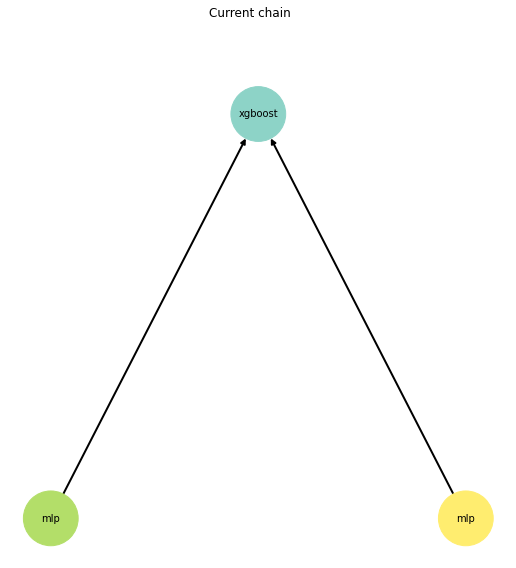

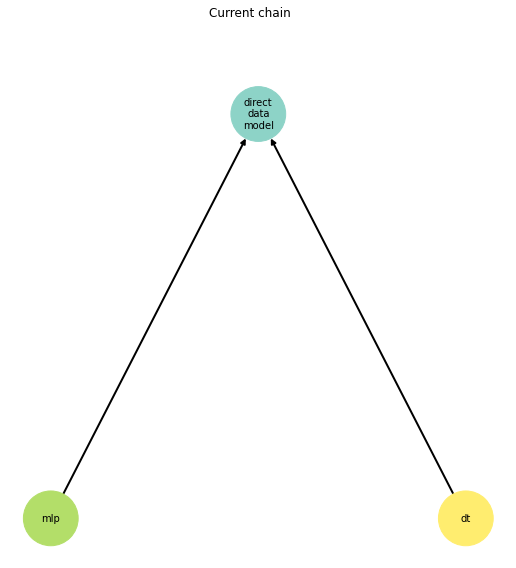

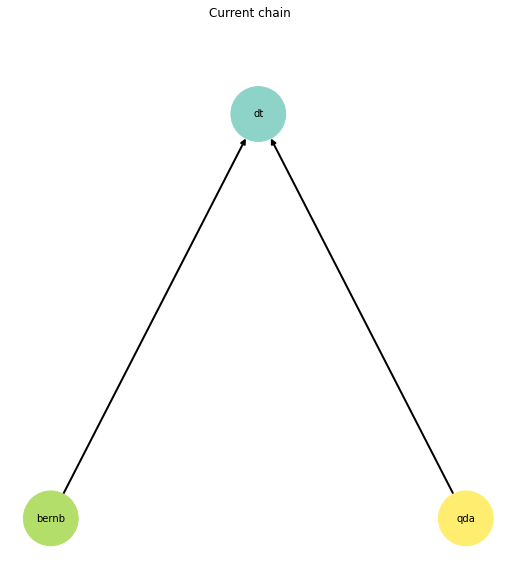

Start tuning of primary nodes
Model tuning started
Better solution found during hyperparameters tuning
Better solution found during hyperparameters tuning
Model tuning finished
End tuning
Composed ROC AUC of chain 1 is 0.818
Start tuning of primary nodes
End tuning
Composed ROC AUC of chain 2 is 0.828
Start tuning of primary nodes
Model tuning started
Better solution found during hyperparameters tuning
Better solution found during hyperparameters tuning
Model tuning finished
End tuning
Composed ROC AUC of chain 3 is 0.743
Start tuning of primary nodes
Tuning failed because of direct_data_model can not be fitted
End tuning
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "C:\Users\anaxa\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-5cab38dfa4cf>", line 2,

TypeError: object of type 'NoneType' has no len()

In [6]:
full_path_train, full_path_test = get_scoring_data()
chain = run_credit_scoring_problem(full_path_train, full_path_test, is_visualise=True)


In [21]:
graph, labels = chain_as_nx_graph(chain)

In [3]:
l = [['a', 'b'], ['d', 'a']]
m = []
for e in l:
    m = m + e

In [7]:
from pgmpy.models import BayesianModel
bn = BayesianModel(l)

In [11]:
'e' in bn.nodes()

False